In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from PIL import Image
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

<h1>Question 1</h1>

In [9]:
df = pd.read_csv("../Assignment3/Grocery_Items_24.csv") 



In [14]:
# referred from https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/

transactions = []
for i in range(len(df)):
    transactions.append([str(item) for item in df.iloc[i, :]])

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded = df_encoded.drop('nan', axis=1) # cleaning the dataset with null values

df_encoded.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:

min_support = 0.01  
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

# Generating association rules
min_confidence = 0.1 
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# Print the association rules
print("Association Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence']])

Association Rules:
          antecedents         consequents   support  confidence
0        (rolls/buns)  (other vegetables)  0.011250    0.100559
1  (other vegetables)        (whole milk)  0.016125    0.131365
2        (whole milk)  (other vegetables)  0.016125    0.103365
3        (rolls/buns)        (whole milk)  0.013500    0.120670
4              (soda)        (whole milk)  0.011375    0.121495


In [16]:
def count_rules(min_support, min_confidence):
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    return len(rules),rules

#  the range of min_support values and min_confidence thresholds given
min_support_values = [0.001, 0.005, 0.01, 0.05]
min_confidence_thresholds = [0.05, 0.075, 0.1]
assoc_rules = pd.DataFrame(index=min_support_values, columns=min_confidence_thresholds)
results = pd.DataFrame(index=min_support_values, columns=min_confidence_thresholds)

# Iterate over min_support values and min_confidence thresholds to count the number of rules
for min_support in min_support_values:
    for min_confidence in min_confidence_thresholds:
        num_rules,rules = count_rules(min_support, min_confidence)
        results.at[min_support, min_confidence] = num_rules
        assoc_rules.at[min_support, min_confidence] = rules

# References:
# - Pandas Documentation: https://pandas.pydata.org/pandas-docs/stable/
# - mlxtend Documentation: http://rasbt.github.io/mlxtend/

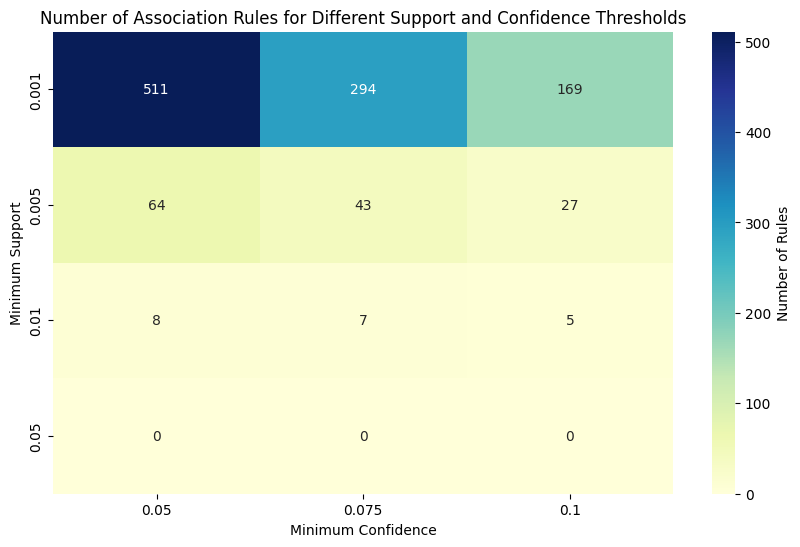

In [17]:
# reffered from https://seaborn.pydata.org/generated/seaborn.heatmap.html
results = results.apply(pd.to_numeric)

plt.figure(figsize=(10, 6))
sns.heatmap(results, annot=True, cmap="YlGnBu", fmt='g', cbar_kws={'label': 'Number of Rules'})
plt.title('Number of Association Rules for Different Support and Confidence Thresholds')
plt.xlabel('Minimum Confidence')
plt.ylabel('Minimum Support')

plt.show()



In [18]:
min_support = 0.005
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.0)

filtered_rules = rules[rules['support'] >= min_support]

max_confidence_rule = filtered_rules[filtered_rules['confidence'] == filtered_rules['confidence'].max()]

print("Association Rule with the Highest Confidence and Minimum Support 0.005:")
print(max_confidence_rule[['antecedents', 'consequents', 'support', 'confidence']])


# References:
# - Pandas Documentation: https://pandas.pydata.org/pandas-docs/stable/
# - mlxtend Documentation: http://rasbt.github.io/mlxtend/

Association Rule with the Highest Confidence and Minimum Support 0.005:
        antecedents   consequents  support  confidence
64  (shopping bags)  (whole milk)   0.0075    0.150754


The confidence value is 0.150754

<h1>Question 2</h1>


In [21]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# label map and data directory
labmap = {0: "n02089078-black-and-tan_coonhound",
          1: "n02091831-Saluki",
          2: "n02092002-Scottish_deerhound",
          3: "n02095314-wire-haired_fox_terrier"}

data_directory = '../DataSet/ProcessedDatasets/'

# parameters
batch_size = 8
image_size = (331, 331)
epochs = 20

# an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% training, 20% validation
)

# data generators
train_generator = datagen.flow_from_directory(
    data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=list(labmap.values()),
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=list(labmap.values()),
    subset='validation'
)
# References:
# - TensorFlow Documentation: https://www.tensorflow.org/
# - Keras Documentation: https://keras.io/
# - Matplotlib Documentation: https://matplotlib.org/
# - ImageDataGenerator Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# - Python os Module Documentation: https://docs.python.org/3/library/os.html

Found 600 images belonging to 4 classes.
Found 148 images belonging to 4 classes.


3,3 Filter Size




Epoch 1/20


75/75 [==============================] - 4s 43ms/step - loss: 4.1360 - accuracy: 0.3367 - val_loss: 1.2946 - val_accuracy: 0.3819
Epoch 2/20
75/75 [==============================] - 3s 38ms/step - loss: 1.1542 - accuracy: 0.5050 - val_loss: 1.2392 - val_accuracy: 0.4653
Epoch 3/20
75/75 [==============================] - 3s 39ms/step - loss: 0.8351 - accuracy: 0.6883 - val_loss: 1.1141 - val_accuracy: 0.5625
Epoch 4/20
75/75 [==============================] - 3s 40ms/step - loss: 0.5563 - accuracy: 0.8233 - val_loss: 1.3238 - val_accuracy: 0.5694
Epoch 5/20
75/75 [==============================] - 3s 39ms/step - loss: 0.3286 - accuracy: 0.9000 - val_loss: 1.2650 - val_accuracy: 0.6111
Epoch 6/20
75/75 [==============================] - 3s 38ms/step - loss: 0.2043 - accuracy: 0.9550 - val_loss: 1.2455 - val_accuracy: 0.6250
Epoch 7/20
75/75 [==============================] - 3s 39ms/step - loss: 0.1183 - accuracy: 0.9750 - val_loss: 1.1754 - val_accuracy: 0.6042
Epoch 8/

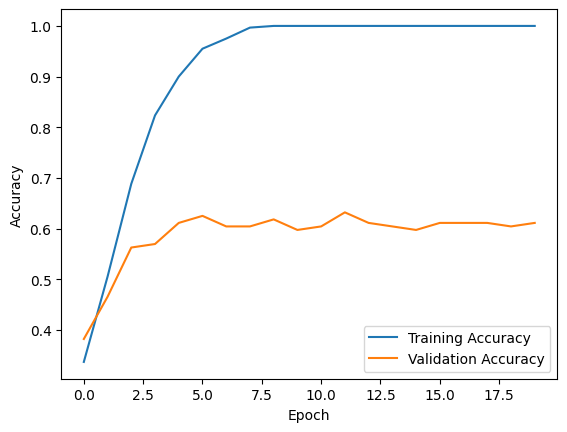

In [22]:

model0 = models.Sequential()

# Convolutional Layer with 8 3 × 3 filters
model0.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(331, 331, 3)))

# 1 max pooling with 2 × 2 pool size
model0.add(layers.MaxPooling2D((2, 2)))

# Flatten the Tensor
model0.add(layers.Flatten())

# 1 hidden layer with 16 nodes for a fully connected neural network
model0.add(layers.Dense(16, activation='relu'))

# Output layer has 4 nodes (since 4 classes) using ‘softmax’ activation function
model0.add(layers.Dense(4, activation='softmax'))

# Compile the model
model0.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model0.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# References:
# - TensorFlow Documentation: https://www.tensorflow.org/
# - Keras Documentation: https://keras.io/
# - Matplotlib Documentation: https://matplotlib.org/

Rowan Banner ID: 916459193
<br/>
(a) 5*5 Filter Size

Epoch 1/20
75/75 [==============================] - 3s 38ms/step - loss: 1.5747 - accuracy: 0.3583 - val_loss: 1.3283 - val_accuracy: 0.3542
Epoch 2/20
75/75 [==============================] - 3s 37ms/step - loss: 1.1197 - accuracy: 0.5583 - val_loss: 1.2703 - val_accuracy: 0.4444
Epoch 3/20
75/75 [==============================] - 3s 37ms/step - loss: 0.6684 - accuracy: 0.7783 - val_loss: 1.5460 - val_accuracy: 0.4375
Epoch 4/20
75/75 [==============================] - 3s 38ms/step - loss: 0.2577 - accuracy: 0.9333 - val_loss: 1.6207 - val_accuracy: 0.4236
Epoch 5/20
75/75 [==============================] - 3s 37ms/step - loss: 0.0844 - accuracy: 0.9850 - val_loss: 1.9859 - val_accuracy: 0.4236
Epoch 6/20
75/75 [==============================] - 3s 36ms/step - loss: 0.0439 - accuracy: 0.9950 - val_loss: 2.0601 - val_accuracy: 0.4514
Epoch 7/20
75/75 [==============================] - 3s 37ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 2.8334 - val_accuracy: 0.4167
Epoch 8/20
75

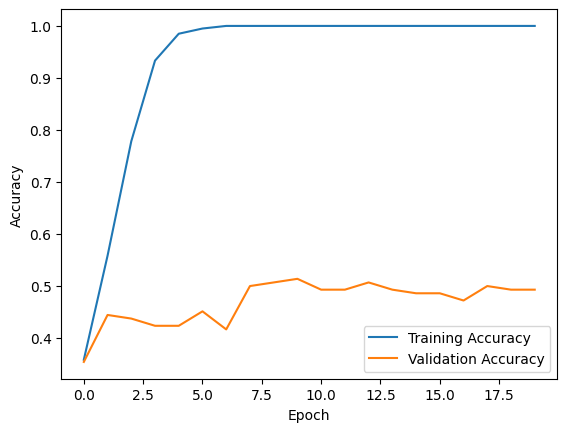

In [23]:

model1 = models.Sequential()

# Convolutional Layer with 8 5 × 5 filters
model1.add(layers.Conv2D(8, (5, 5), activation='relu', input_shape=(331, 331, 3)))

# 1 max pooling with 2 × 2 pool size
model1.add(layers.MaxPooling2D((2, 2)))

# Flatten the Tensor
model1.add(layers.Flatten())

# 1 hidden layer with 16 nodes for a fully connected neural network
model1.add(layers.Dense(16, activation='relu'))

# Output layer has 4 nodes (since 4 classes) using ‘softmax’ activation function
model1.add(layers.Dense(4, activation='softmax'))

# Compile the model
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# References:
# - TensorFlow Documentation: https://www.tensorflow.org/
# - Keras Documentation: https://keras.io/
# - Matplotlib Documentation: https://matplotlib.org/

7*7 Filter Size

Epoch 1/20
75/75 [==============================] - 3s 39ms/step - loss: 2.2570 - accuracy: 0.3050 - val_loss: 1.3827 - val_accuracy: 0.3264
Epoch 2/20
75/75 [==============================] - 3s 37ms/step - loss: 1.3881 - accuracy: 0.3150 - val_loss: 1.3724 - val_accuracy: 0.3125
Epoch 3/20
75/75 [==============================] - 3s 38ms/step - loss: 1.3665 - accuracy: 0.3167 - val_loss: 1.3398 - val_accuracy: 0.3333
Epoch 4/20
75/75 [==============================] - 3s 38ms/step - loss: 1.2476 - accuracy: 0.3483 - val_loss: 1.3240 - val_accuracy: 0.3542
Epoch 5/20
75/75 [==============================] - 3s 37ms/step - loss: 1.1215 - accuracy: 0.4217 - val_loss: 1.5118 - val_accuracy: 0.3611
Epoch 6/20
75/75 [==============================] - 3s 37ms/step - loss: 0.9036 - accuracy: 0.6633 - val_loss: 1.3388 - val_accuracy: 0.4514
Epoch 7/20
75/75 [==============================] - 3s 37ms/step - loss: 0.7722 - accuracy: 0.7667 - val_loss: 1.3937 - val_accuracy: 0.4375
Epoch 8/20
75

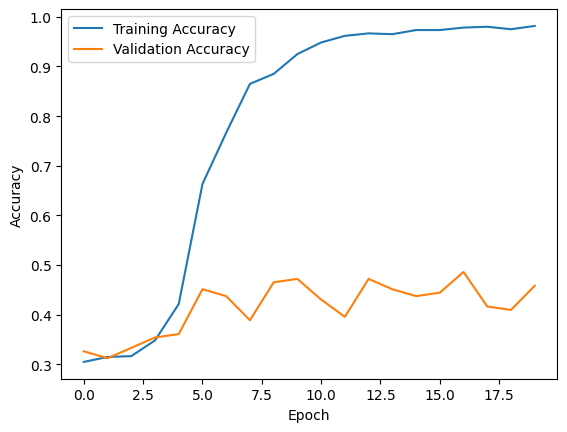

In [24]:

model2 = models.Sequential()

# Convolutional Layer with 8 7 × 7 filters
model2.add(layers.Conv2D(8, (7, 7), activation='relu', input_shape=(331, 331, 3)))

# 1 max pooling with 2 × 2 pool size
model2.add(layers.MaxPooling2D((2, 2)))

# Flatten the Tensor
model2.add(layers.Flatten())

# 1 hidden layer with 16 nodes for a fully connected neural network
model2.add(layers.Dense(16, activation='relu'))

# Output layer has 4 nodes (since 4 classes) using ‘softmax’ activation function
model2.add(layers.Dense(4, activation='softmax'))

# Compile the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# References:
# - TensorFlow Documentation: https://www.tensorflow.org/
# - Keras Documentation: https://keras.io/
# - Matplotlib Documentation: https://matplotlib.org/

<h1>Observation</h1>
<br/>
<p1>
The models upon slowly increasing the filter size the validation accuracy is slowly decreasing which suggests that the model is being overfit.

The first model with a 3x3 filter is close to just right with the training and validation accuracies of (100,61.11) respectively

The first model with a 5x5 filter is overfit with the training and validation accuracies of 
(100,49.31) respectively

The first model with a 7x7 filter is overfit with the training and validation accuracies of 
(98.17,45.83) respectively

Model can be overfit when the training accuracy is very high and the validation accuracy is very low.
Model can be underfit when the training accuracy is very low along with the validation accuracy.
</p1>


# References:
 - Pandas Documentation: https://pandas.pydata.org/pandas-docs/stable/
 - mlxtend Documentation: http://rasbt.github.io/mlxtend/
 - TensorFlow Documentation: https://www.tensorflow.org/
 - Keras Documentation: https://keras.io/
 - Matplotlib Documentation: https://matplotlib.org/
 - ImageDataGenerator Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
